In [2]:
pip install optuna

Importing necessary libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import optuna
import torch.optim.lr_scheduler as lr_scheduler
import joblib


Loading the dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 45.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Subset creation for classes deer and horse

In [5]:
train_mask = torch.tensor([(target == 7 or target == 4) for target in trainset.targets])
test_mask = torch.tensor([(target == 7 or target == 4) for target in testset.targets])

trainset.data = trainset.data[train_mask]
trainset.targets = torch.tensor(trainset.targets)[train_mask]
testset.data = testset.data[test_mask]
testset.targets = torch.tensor(testset.targets)[test_mask]

Converting to binary(1-Deer, 0-Horse)

In [6]:
trainset.targets = torch.tensor([1 if target == 4 else 0 for target in trainset.targets])
testset.targets = torch.tensor([1 if target == 4 else 0 for target in testset.targets])

In [7]:
generator = torch.Generator().manual_seed(42)

Splitting the dataset into train,test and validation sets

In [8]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size], generator=generator)
print(len(train_dataset), len(val_dataset), len(testset))

8000 2000 2000


Class distribution

Label
1    5000
0    5000
Name: count, dtype: int64


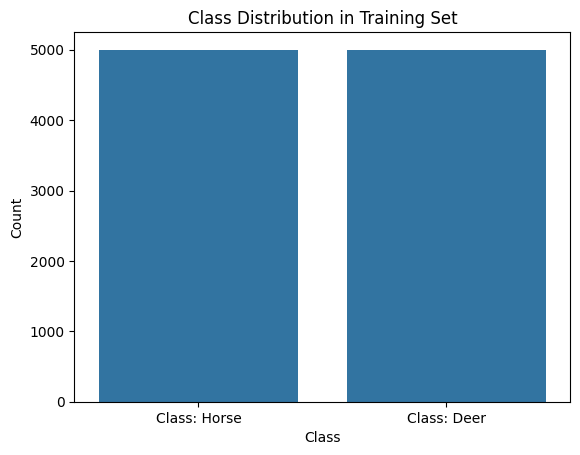

In [9]:
y_train = trainset.targets

df = pd.DataFrame({'Label': y_train})
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class: Horse', 'Class: Deer'])
plt.show()

In [10]:
print(f"Image shape: {trainset.data[0].shape}")
print(f"Image data type: {trainset.data.dtype}")

Image shape: (32, 32, 3)
Image data type: uint8


Displaying sample images

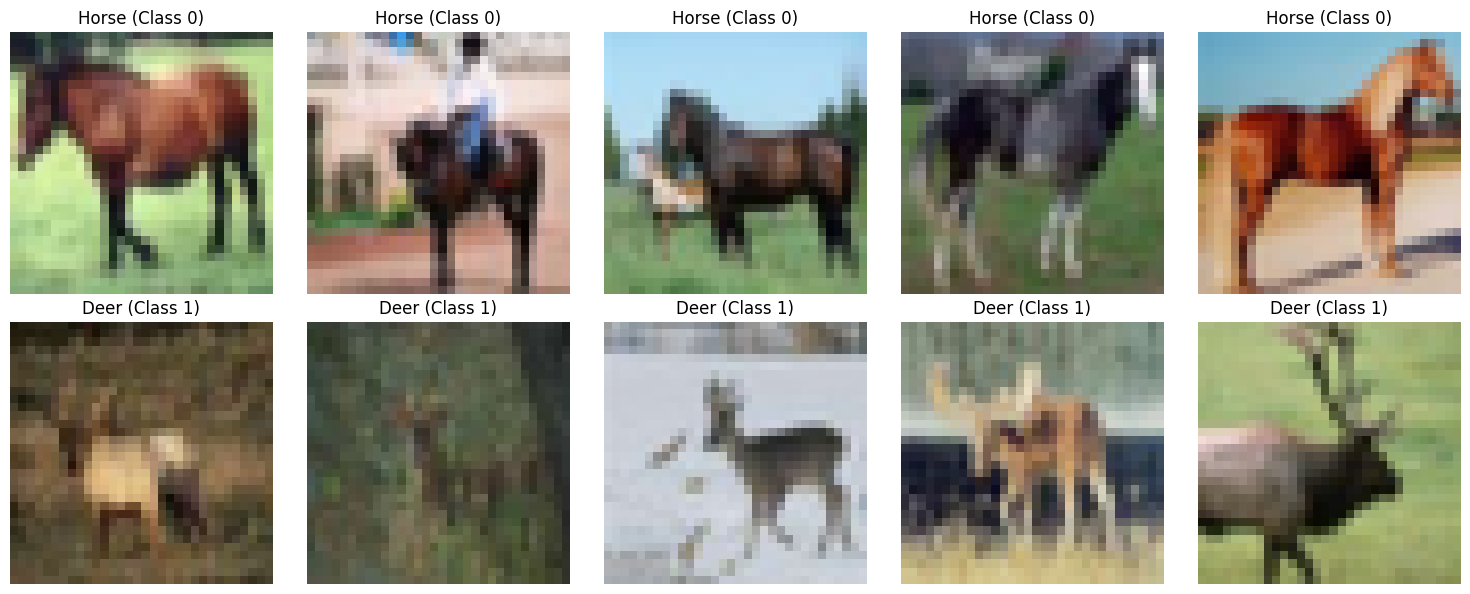

In [11]:
def plot_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    horse_idx = np.where(dataset.targets == 0)[0][:num_samples]
    deer_idx = np.where(dataset.targets == 1)[0][:num_samples]

    for i in range(num_samples):
        axes[0, i].imshow(dataset.data[horse_idx[i]])
        axes[0, i].set_title('Horse (Class 0)')
        axes[0, i].axis('off')

        axes[1, i].imshow(dataset.data[deer_idx[i]])
        axes[1, i].set_title('Deer (Class 1)')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(trainset)


Preparing data

In [12]:
def prepare_data(dataset):
    if hasattr(dataset, 'dataset'):
        data = dataset.dataset.data[dataset.indices]
    else:
        data = dataset.data
    return data.reshape(len(data), -1).astype(np.float32) / 255.0

X_train = prepare_data(train_dataset)
X_val = prepare_data(val_dataset)
X_test = prepare_data(testset)

y_train = trainset.targets[train_dataset.indices].numpy()
y_val = trainset.targets[val_dataset.indices].numpy()
y_test = testset.targets.numpy()

Applying PCA

In [13]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

Plotting PCA CEVR

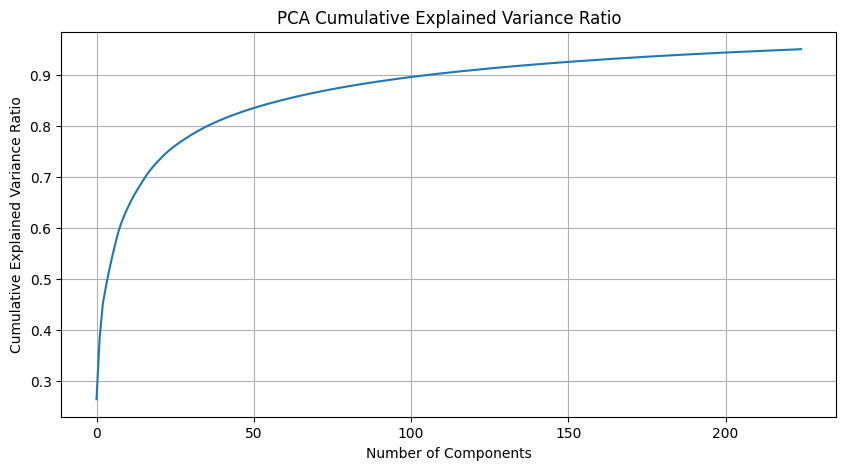

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [15]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_pca), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val_pca), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test_pca), torch.LongTensor(y_test))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Initial modeling of PCA+FNN

In [16]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(FCNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc_layers(x)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Initial parameters

In [18]:
input_size = X_train_pca.shape[1]
hidden_sizes = [128, 64]
output_size = 1
learning_rate = 0.001
num_epochs = 30

In [19]:
model = FCNN(input_size, hidden_sizes, output_size).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Model training

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.float().to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(output) > 0.5).float()
        total += target.size(0)
        correct += (predicted.squeeze() == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().to(device)
            output = model(data)
            loss = criterion(output.squeeze(), target)

            val_loss += loss.item()
            predicted = (torch.sigmoid(output) > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted.squeeze() == target).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print('-' * 60)


Epoch [1/30]:
Training Loss: 0.5640, Training Accuracy: 69.95%
Validation Loss: 0.4685, Validation Accuracy: 77.45%
------------------------------------------------------------
Epoch [2/30]:
Training Loss: 0.4054, Training Accuracy: 81.69%
Validation Loss: 0.4268, Validation Accuracy: 80.40%
------------------------------------------------------------
Epoch [3/30]:
Training Loss: 0.3365, Training Accuracy: 85.89%
Validation Loss: 0.4105, Validation Accuracy: 81.50%
------------------------------------------------------------
Epoch [4/30]:
Training Loss: 0.2704, Training Accuracy: 89.12%
Validation Loss: 0.4238, Validation Accuracy: 81.20%
------------------------------------------------------------
Epoch [5/30]:
Training Loss: 0.2118, Training Accuracy: 91.70%
Validation Loss: 0.4322, Validation Accuracy: 82.45%
------------------------------------------------------------
Epoch [6/30]:
Training Loss: 0.1541, Training Accuracy: 94.21%
Validation Loss: 0.5312, Validation Accuracy: 81.30%

Evaluation of initial model

In [21]:
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.float().to(device)
        output = model(data)
        loss = criterion(output.squeeze(), target)

        test_loss += loss.item()
        probs = torch.sigmoid(output)
        predicted = (probs > 0.5).float()

        test_total += target.size(0)
        test_correct += (predicted.squeeze() == target).sum().item()

        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.squeeze().cpu().numpy())
        y_prob.extend(probs.squeeze().cpu().numpy())

# Calculating metrics
test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Calculating per-class accuracy
class_accuracies = []
for i in range(2):
    mask = (np.array(y_true) == i)
    class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
    class_accuracies.append(class_acc)

# Storing metrics
metrics = {
    'fpr': fpr,
    'tpr': tpr,
    'auc': roc_auc,
    'class_accuracies': class_accuracies,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss
}

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nPer-class Accuracy:")
print(f"Horse (Class 0): {class_accuracies[0]:.2f}%")
print(f"Deer (Class 1): {class_accuracies[1]:.2f}%")


Test Results:
Test Loss: 1.2077
Test Accuracy: 82.50%
ROC AUC: 0.8969

Per-class Accuracy:
Horse (Class 0): 82.30%
Deer (Class 1): 82.70%


Plotting ROC and Per class accuracy

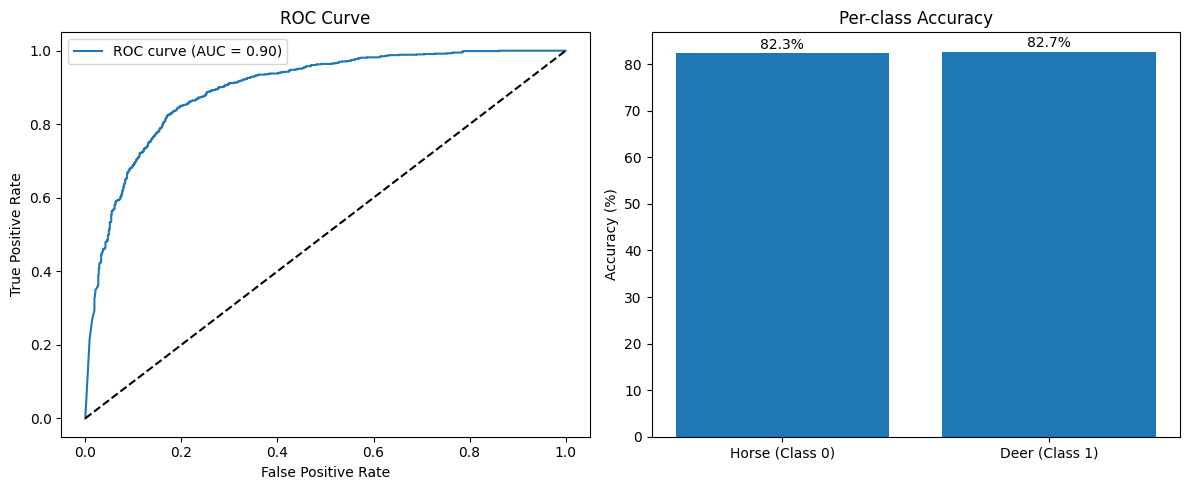

In [22]:
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(metrics['fpr'], metrics['tpr'], label=f'ROC curve (AUC = {metrics["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Per-class Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Horse (Class 0)', 'Deer (Class 1)'], metrics['class_accuracies'])
plt.title('Per-class Accuracy')
plt.ylabel('Accuracy (%)')
for i, acc in enumerate(metrics['class_accuracies']):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')

plt.tight_layout()
plt.show()

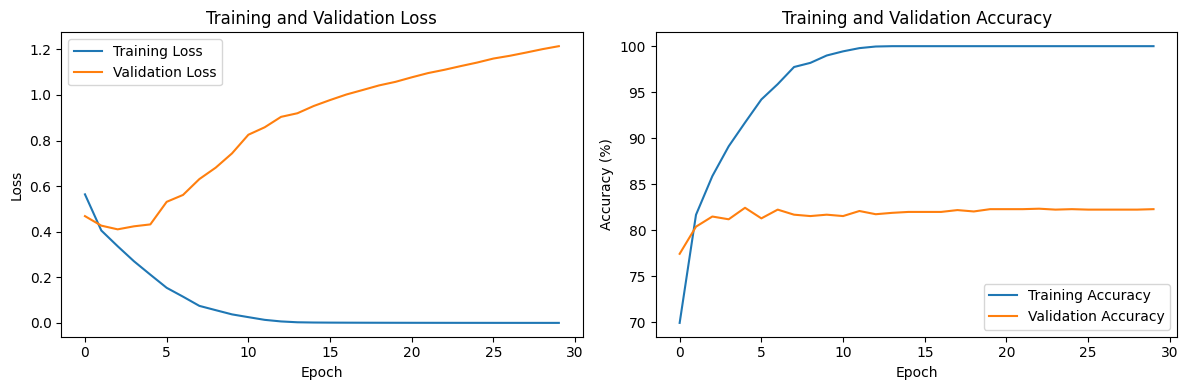

In [23]:
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix

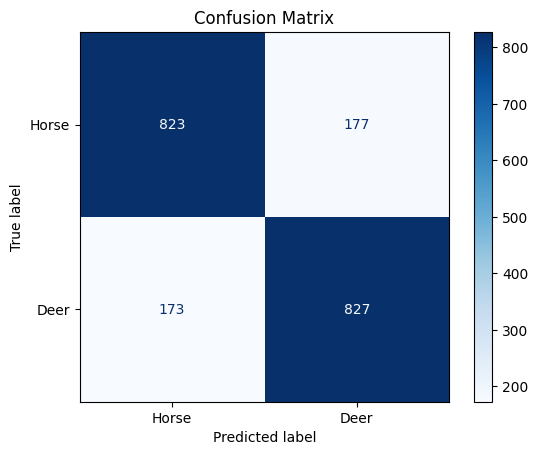

In [24]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Horse', 'Deer'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Hyperparameter tuning using Optuna

In [25]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1, dropout_rate=0.0):
        super(FCNN, self).__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc_layers(x)

In [26]:
def objective(trial):
    n_components = trial.suggest_int('n_components', 2, 100)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_sizes = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True),
        'lr_scheduler': trial.suggest_categorical('lr_scheduler', ['step', 'exponential', 'none'])
    }

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    model = FCNN(
        input_size=X_train_pca.shape[1],
        hidden_sizes=hidden_sizes,
        output_size=1,
        dropout_rate=params['dropout_rate']
    ).to(device)

    train_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_train_pca).to(device),
                      torch.FloatTensor(y_train).to(device)),
        batch_size=params['batch_size'],
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_val_pca).to(device),
                      torch.FloatTensor(y_val).to(device)),
        batch_size=params['batch_size'],
        shuffle=False
    )

    criterion = nn.BCEWithLogitsLoss()

    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'],
                             weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'],
                            momentum=0.9, weight_decay=params['weight_decay'])
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'],
                                 weight_decay=params['weight_decay'])

    if params['lr_scheduler'] == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif params['lr_scheduler'] == 'exponential':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    else:
        scheduler = None

    for epoch in range(30):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        accuracy = val_correct / val_total
        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

[I 2024-12-03 22:45:55,701] A new study created in memory with name: no-name-d53427ad-4ac1-4969-b5df-1dd5b976257d
[I 2024-12-03 22:46:08,396] Trial 0 finished with value: 0.8325 and parameters: {'n_components': 67, 'n_layers': 1, 'n_units_l0': 227, 'learning_rate': 0.002131844449473163, 'batch_size': 64, 'optimizer': 'adam', 'dropout_rate': 0.46236971977365315, 'weight_decay': 3.279024662429585e-05, 'lr_scheduler': 'step'}. Best is trial 0 with value: 0.8325.
[I 2024-12-03 22:46:17,941] Trial 1 finished with value: 0.673 and parameters: {'n_components': 3, 'n_layers': 2, 'n_units_l0': 35, 'n_units_l1': 49, 'learning_rate': 0.0002863837324105325, 'batch_size': 64, 'optimizer': 'rmsprop', 'dropout_rate': 0.236153031085913, 'weight_decay': 0.0006356031107340101, 'lr_scheduler': 'exponential'}. Best is trial 0 with value: 0.8325.
[I 2024-12-03 22:46:29,493] Trial 2 finished with value: 0.7615 and parameters: {'n_components': 16, 'n_layers': 2, 'n_units_l0': 45, 'n_units_l1': 65, 'learning_

In [28]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params

Best trial:
  Value:  0.8355
  Params: 
    n_components: 72
    n_layers: 1
    n_units_l0: 188
    learning_rate: 0.0029082163342016008
    batch_size: 32
    optimizer: adam
    dropout_rate: 0.47648741239870984
    weight_decay: 8.215978346909116e-05
    lr_scheduler: step


Training final model on best parameters

In [29]:
best_n_components = study.best_params['n_components']
hidden_sizes = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]
best_dropout_rate = study.best_params['dropout_rate']
best_learning_rate = study.best_params['learning_rate']
best_batch_size = study.best_params['batch_size']
best_optimizer = study.best_params['optimizer']
best_weight_decay = study.best_params['weight_decay']
best_lr_scheduler = study.best_params['lr_scheduler']

# Applying PCA with best number of components
pca_final = PCA(n_components=best_n_components)
X_train_pca_final = pca_final.fit_transform(X_train)
X_val_pca_final = pca_final.transform(X_val)
X_test_pca_final = pca_final.transform(X_test)

# Creating final model
final_model = FCNN(
    input_size=X_train_pca_final.shape[1],
    hidden_sizes=hidden_sizes,
    output_size=1,
    dropout_rate=best_dropout_rate
).to(device)

train_loader_final = DataLoader(
    TensorDataset(torch.FloatTensor(X_train_pca_final).to(device),
                  torch.FloatTensor(y_train).to(device)),
    batch_size=best_batch_size,
    shuffle=True
)
val_loader_final = DataLoader(
    TensorDataset(torch.FloatTensor(X_val_pca_final).to(device),
                  torch.FloatTensor(y_val).to(device)),
    batch_size=best_batch_size,
    shuffle=False
)
test_loader_final = DataLoader(
    TensorDataset(torch.FloatTensor(X_test_pca_final).to(device),
                  torch.FloatTensor(y_test).to(device)),
    batch_size=best_batch_size,
    shuffle=False
)

Plotting the final PCA CEVR

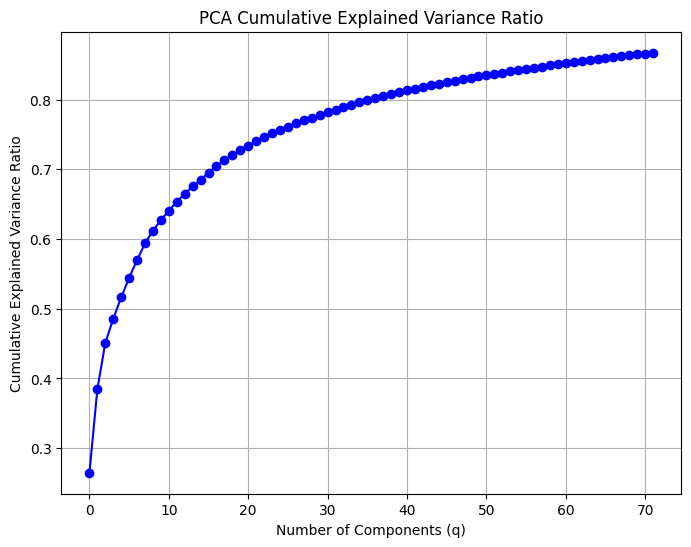

Total variance explained by 72 components: 0.8672


In [30]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_final.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components (q)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

print(f"Total variance explained by {best_n_components} components: {np.sum(pca_final.explained_variance_ratio_):.4f}")

Final model training with early stopping to prevent overfitting

In [31]:
# Training setup
criterion = nn.BCEWithLogitsLoss()
if best_optimizer == 'adam':
    optimizer = optim.Adam(final_model.parameters(),
                          lr=best_learning_rate,
                          weight_decay=best_weight_decay)
elif best_optimizer == 'sgd':
    optimizer = optim.SGD(final_model.parameters(),
                         lr=best_learning_rate,
                         momentum=0.9,
                         weight_decay=best_weight_decay)
else:
    optimizer = optim.RMSprop(final_model.parameters(),
                             lr=best_learning_rate,
                             weight_decay=best_weight_decay)

# Initializing learning rate scheduler
if best_lr_scheduler == 'step':
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
elif best_lr_scheduler == 'exponential':
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
else:
    scheduler = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop with early stopping
best_val_acc = 0
patience = 5
counter = 0
num_epochs = 50

for epoch in range(num_epochs):
    # Training phase
    final_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_X, batch_y in train_loader_final:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_total += batch_y.size(0)
        train_correct += (predicted.squeeze() == batch_y).sum().item()

    if scheduler:
        scheduler.step()

    # Validation phase
    final_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader_final:
            outputs = final_model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_total += batch_y.size(0)
            val_correct += (predicted.squeeze() == batch_y).sum().item()

        # Test accuracy
        test_correct = 0
        test_total = 0
        for batch_X, batch_y in test_loader_final:
            outputs = final_model(batch_X)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            test_total += batch_y.size(0)
            test_correct += (predicted.squeeze() == batch_y).sum().item()

    # Calculating metrics
    train_loss = train_loss / len(train_loader_final)
    train_acc = 100 * train_correct / train_total
    val_loss = val_loss / len(val_loader_final)
    val_acc = 100 * val_correct / val_total
    test_acc = 100 * test_correct / test_total

    # Storing metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Accuracy: {test_acc:.2f}%')
    print('-' * 60)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

Epoch [1/50]:
Training Loss: 0.5476, Training Accuracy: 72.55%
Validation Loss: 0.4755, Validation Accuracy: 78.20%
Test Accuracy: 77.75%
------------------------------------------------------------
Epoch [2/50]:
Training Loss: 0.4693, Training Accuracy: 78.25%
Validation Loss: 0.4418, Validation Accuracy: 80.90%
Test Accuracy: 79.40%
------------------------------------------------------------
Epoch [3/50]:
Training Loss: 0.4334, Training Accuracy: 79.99%
Validation Loss: 0.4300, Validation Accuracy: 80.80%
Test Accuracy: 80.40%
------------------------------------------------------------
Epoch [4/50]:
Training Loss: 0.4162, Training Accuracy: 81.34%
Validation Loss: 0.4207, Validation Accuracy: 81.10%
Test Accuracy: 81.40%
------------------------------------------------------------
Epoch [5/50]:
Training Loss: 0.4021, Training Accuracy: 82.21%
Validation Loss: 0.4098, Validation Accuracy: 82.05%
Test Accuracy: 82.25%
------------------------------------------------------------
Epoch

Evaluation of final model

Plots
1.   Training and Testing Accuracy Vs Epochs
2.   ROC
3.   Per class accuracy



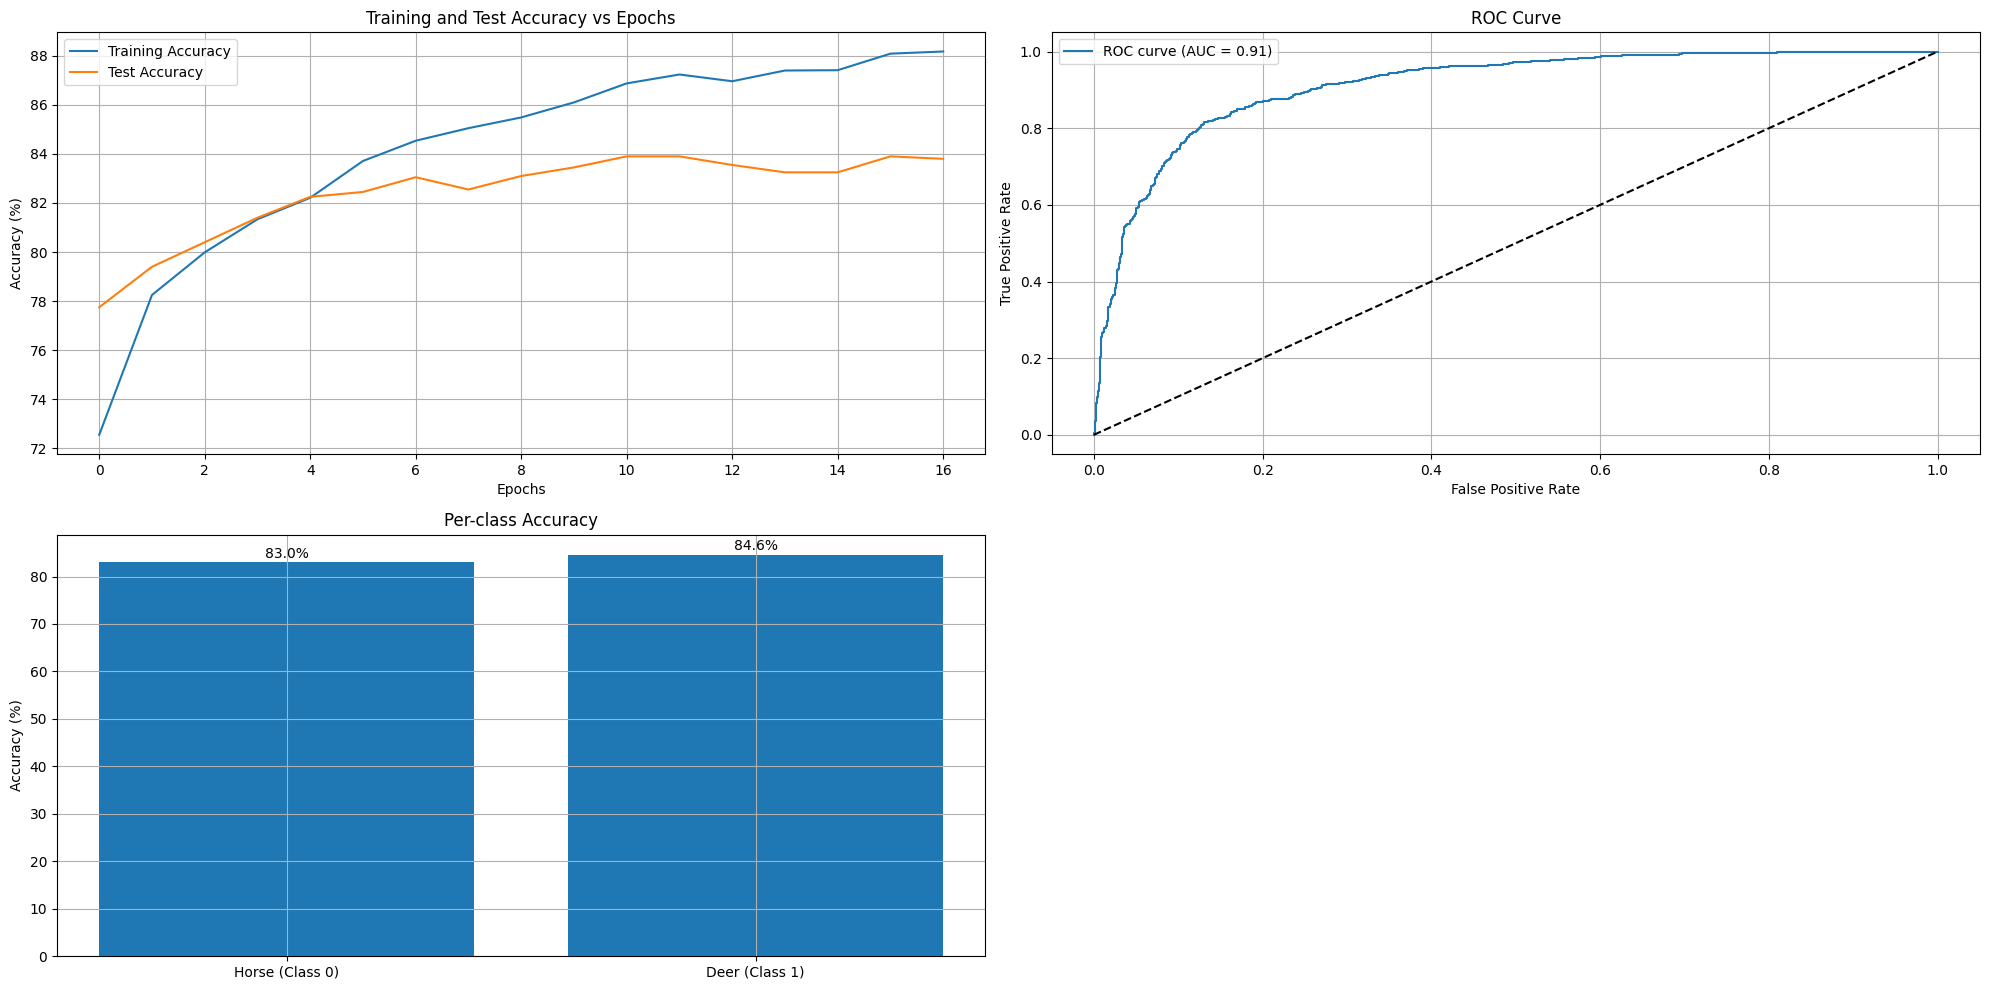

In [32]:
# Final evaluation
final_model.eval()
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for batch_X, batch_y in test_loader_final:
        outputs = final_model(batch_X)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()

        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.squeeze().cpu().numpy())
        y_prob.extend(probs.squeeze().cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Calculating per-class accuracy
class_accuracies = []
for i in range(2):
    mask = (np.array(y_true) == i)
    class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
    class_accuracies.append(class_acc)

plt.figure(figsize=(20, 10))

# Plot 1: Training and Test Accuracy vs Epochs
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)

# Plot 2: ROC Curve
plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Plot 3: Per-class Accuracy
plt.subplot(2, 2, 3)
plt.bar(['Horse (Class 0)', 'Deer (Class 1)'], class_accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy')
for i, acc in enumerate(class_accuracies):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')
plt.grid(True)

plt.tight_layout()
plt.show()

Plot for traing and test accuracy vs learning rate

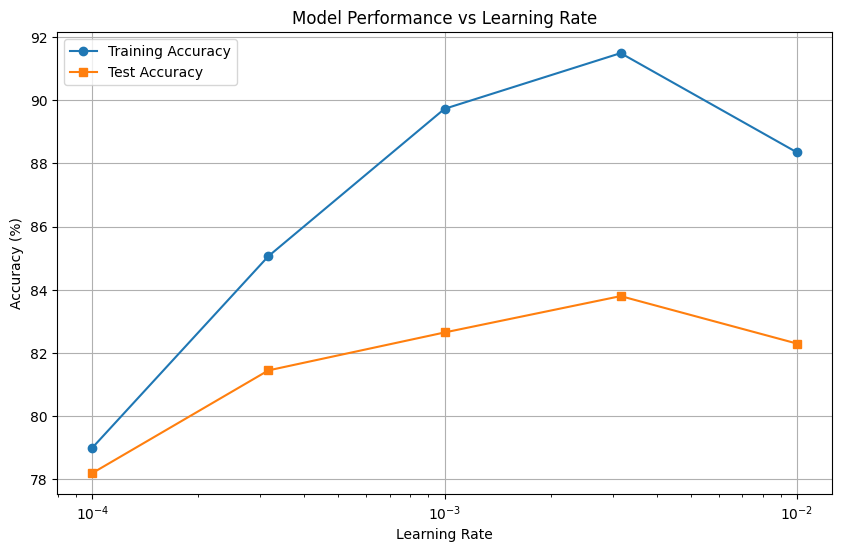


Final Results:
Best Validation Accuracy: 83.15%
ROC AUC: 0.9108

Per-class Accuracy:
Horse (Class 0): 83.00%
Deer (Class 1): 84.60%


In [34]:
lr_results = {}
learning_rates = np.logspace(-4, -2, num=5)
for lr in learning_rates:
    model = FCNN(
        input_size=X_train_pca_final.shape[1],
        hidden_sizes=hidden_sizes,
        output_size=1,
        dropout_rate=best_dropout_rate
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=best_weight_decay)
    lr_results[lr] = {'train_accs': [], 'test_accs': []}

    # Training loop
    for epoch in range(15):
        model.train()
        for data, target in train_loader_final:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_correct = 0
        train_total = 0
        for data, target in train_loader_final:
            output = model(data)
            predicted = (torch.sigmoid(output) > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted.squeeze() == target).sum().item()
        train_acc = 100 * train_correct / train_total

        # Test accuracy
        test_correct = 0
        test_total = 0
        for data, target in test_loader_final:
            output = model(data)
            predicted = (torch.sigmoid(output) > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted.squeeze() == target).sum().item()
        test_acc = 100 * test_correct / test_total

    lr_results[lr]['train_accs'].append(train_acc)
    lr_results[lr]['test_accs'].append(test_acc)

plt.figure(figsize=(10, 6))
lrs = list(lr_results.keys())
train_means = [np.mean(lr_results[lr]['train_accs']) for lr in lrs]
test_means = [np.mean(lr_results[lr]['test_accs']) for lr in lrs]

plt.plot(lrs, train_means, marker='o', label='Training Accuracy')
plt.plot(lrs, test_means, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Results:")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nPer-class Accuracy:")
print(f"Horse (Class 0): {class_accuracies[0]:.2f}%")
print(f"Deer (Class 1): {class_accuracies[1]:.2f}%")

Confusion matrix

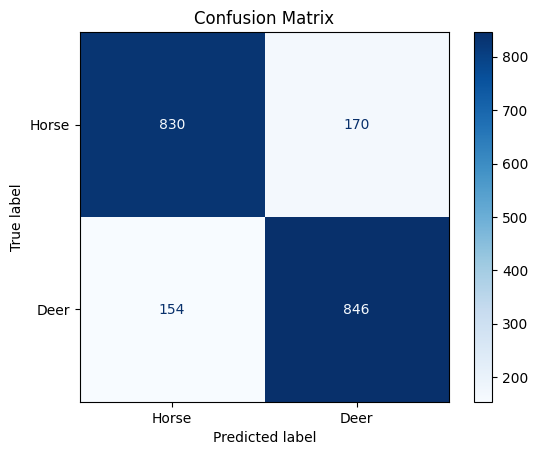

In [35]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Horse', 'Deer'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Saving the final model

In [36]:
joblib.dump(final_model, 'final_model_PCA_FNN.joblib')

['final_model_PCA_FNN.joblib']